# Explorations in OmniSci backend rendering with Vega

We would like to surface the vega rendering backend to Jupyter notebook users.
This will allow people to visualize data that is too large to fit in memory.
OmniSci uses Apache Thrift to generate interfaces to the SQL server for various clients.
The Javascript client is notably more complete than the Python client.

## Establishing a connection

pymapd allows us to connect to a OmniSci server using the following code:

In [1]:
import pymapd
import jupyterlab_omnisci
connection_data = dict(
    user='mapd',
    password='HyperInteractive',
    host='metis.mapd.com',
    port='443',
    dbname='mapd',
    protocol='https'
)
con = pymapd.connect(**connection_data)

Once we have a connection, we can try to send vega data to the backend and render it.
Both the Jupyter notebook client (typically a browser), and the kernel (in this case
a python process) have the ability to make this request. There are a number of different
ways we can try to proceed in the notebook.

## Generate vega in Python, request in the browser, render in notebook

The following cell magic parses yaml data into JSON. This JSON is then sent *to the browser*,
along with the relevant connection data. The browser then makes the request using
the OmniSci browser client, and renders the resulting image in the notebook:

In [2]:
connection_data = dict(
    username='mapd',
    password='HyperInteractive',
    host='metis.mapd.com',
    port='443',
    database='mapd',
    protocol='https'
)

In [3]:
%%omnisci_vega $connection_data

width: 384
height: 564
config:
    ticks: false
data:
  - name: 'tweets'
    sql: 'SELECT goog_x as x, goog_y as y, tweets_nov_feb.rowid FROM tweets_nov_feb' 

scales:
  - name: 'x'
    type: 'linear'
    domain:
      - -3650484.1235206556
      -  7413325.514451755
    range: 'width'
  - name: 'y'
    type: 'linear'
    domain:
      - -5778161.9183506705
      -  10471808.487466192
    range: 'height'
marks:
  - type: 'points'
    from:
      data: 'tweets'
    properties:
      x:
        scale: 'x'
        field: 'x'
      y:
        scale: 'y'
        field: 'y'
      fillColor: 'green'
      size:
        value: 1      

/home/ian/quansight/jupyterlab-omnisci/jupyterlab_omnisci/magics.py:114: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vega = yaml.load(cell)


You can also do the same but for vega lite, which will get translated to vega in the browser before being executed with the omnisci browser client

In [4]:
%%omnisci_vegalite $connection_data

width: 384
height: 564
data:
    sql: 'SELECT goog_x as x, goog_y as y, tweets_nov_feb.rowid FROM tweets_nov_feb'
mark:
    type: circle
    color: green
    size: 1
encoding:
    x:
        field: x
        type: quantitative
        scale:
            range: width
            domain:
              - -3650484.1235206556
              -  7413325.514451755
    y:
        field: y
        type: quantitative
        scale:
            range: height
            domain:
              - -5778161.9183506705
              -  10471808.487466192

/home/ian/quansight/jupyterlab-omnisci/jupyterlab_omnisci/magics.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  vl = yaml.load(cell)


## Write vega directly, request in the browser, render in notebook

We don't necessarily need to use yaml as the input format. The following takes a JSON
string and sends it to the browser, along with the connection data:

In [5]:
import json

connection_data = dict(
    username='mapd',
    password='HyperInteractive',
    host='vega-demo.mapd.com',
    port='9092',
    database='mapd',
    protocol='http'
)

vega1 = """ {
  "width": 733,
  "height": 530,
  "data": [
    {
      "name": "heatmap_query",
      "sql": "SELECT rect_pixel_bin(conv_4326_900913_x(lon), -13847031.457875465, -7451726.712679257, 733, 733) as x,
                     rect_pixel_bin(conv_4326_900913_y(lat), 2346114.147993467, 6970277.197053557, 530, 530) as y,
                     SUM(amount) as cnt
                     FROM fec_contributions_oct
                     WHERE (lon >= -124.39000000000038 AND lon <= -66.93999999999943) AND
                           (lat >= 20.61570573311549 AND lat <= 52.93117449504004) AND
                           amount > 0 AND
                           recipient_party = 'R'
                           GROUP BY x, y"
    }
  ],
  "scales": [
    {
      "name": "heat_color",
      "type": "quantize",
      "domain": [
        10000.0,
        1000000.0
      ],
      "range": [ "#0d0887", "#2a0593", "#41049d", "#5601a4", "#6a00a8",
                 "#7e03a8", "#8f0da4", "#a11b9b", "#b12a90", "#bf3984",
                 "#cb4679", "#d6556d", "#e16462", "#ea7457", "#f2844b",
                 "#f89540", "#fca636", "#feba2c", "#fcce25", "#f7e425", "#f0f921"
      ],
      "default": "#0d0887",
      "nullValue": "#0d0887"
    }
  ],
  "marks": [
    {
      "type": "symbol",
      "from": {
        "data": "heatmap_query"
      },
      "properties": {
        "shape": "square",
        "x": {
          "field": "x"
        },
        "y": {
          "field": "y"
        },
        "width": 1,
        "height": 1,
        "fillColor": {
          "scale": "heat_color",
          "field": "cnt"
        }
      }
    }
  ]
}""".replace('\n', '')
im = jupyterlab_omnisci.OmniSciVegaRenderer(connection_data, json.loads(vega1))
display(im)

## Requesting in Python

Making the omnisci request in the browser has a major drawback, in that the image data is not
easily available to the python kernel. Instead, we can make the request on the Python side:

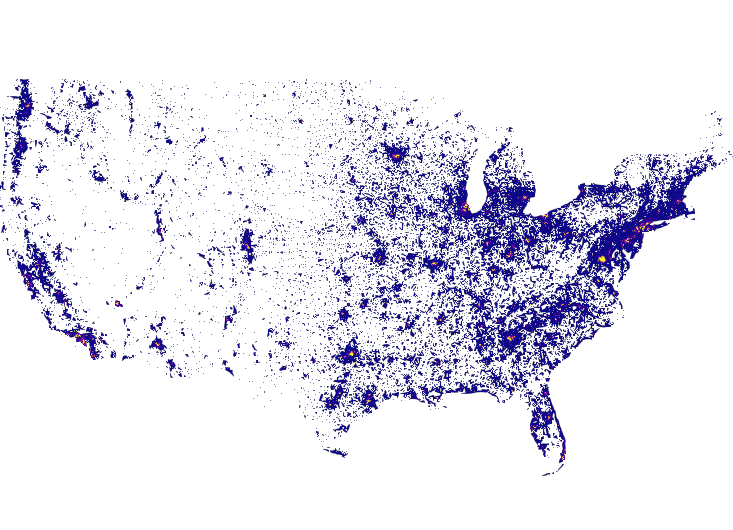

In [6]:
connection_data = dict(
    user='mapd',
    password='HyperInteractive',
    host='vega-demo.mapd.com',
    port='9092',
    dbname='mapd',
    protocol='http'
)
con = pymapd.connect(**connection_data)
con.render_vega(vega1)